In [1]:
import torch
from torch.autograd import Variable
import utils
import dataset
from PIL import Image

import models.crnn as crnn


model_path = '/image/Chen/crnn.pytorch/data/crnnV2.pkl'
img_path = '/image/data/GF10015878680062.jpg'
alphabet = '零壹貳參肆伍陸柒捌玖拾佰仟萬億兆元整'
# alphabet = alphabet + '-'
# alphabet_dict = {}
# for i, char in enumerate(alphabet):
#     # NOTE: 0 is reserved for 'blank' required by wrap_ctc
#     alphabet_dict[char] = i + 1

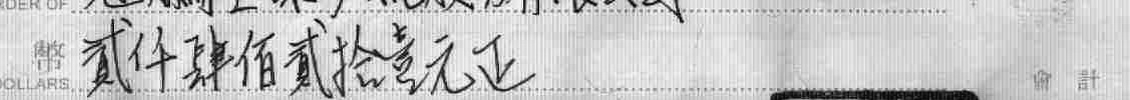

In [2]:
Image.open(img_path).convert('L')

In [3]:
model = crnn.CRNN(32, 1, 19, 256)



if torch.cuda.is_available():
    model = model.cuda()
print('loading pretrained model from %s' % model_path)
model.load_state_dict(torch.load(model_path))



converter = utils.strLabelConverter(alphabet)

transformer = dataset.resizeNormalize((320, 32))
image = Image.open(img_path).convert('L')
image = transformer(image)
if torch.cuda.is_available():
    image = image.cuda()
image = image.view(1, *image.size())
image = Variable(image)

model.eval()
preds = model(image)

_, preds = preds.max(2)
preds = preds.transpose(1, 0).contiguous().view(-1)

preds_size = Variable(torch.IntTensor([preds.size(0)]))
raw_pred = converter.decode(preds.data, preds_size.data, raw=True)
sim_pred = converter.decode(preds.data, preds_size.data, raw=False)
print(preds.data, preds_size.data)
print('%-20s => %-20s' % (raw_pred, sim_pred))


loading pretrained model from /image/Chen/crnn.pytorch/data/crnnV2.pkl

  1
  5
  1
  5
 13
 12
  5
 10
 10
 12
  5
 11
 15
 14
 15
 17
 18
  1
  3
  1
  1
  1
  1
 17
 10
 17
  3
  5
 12
 11
  3
 10
 11
 18
 14
 11
 11
 15
 15
 11
 11
  1
  1
  1
  1
  1
  1
  1
  1
  1
 11
  9
  4
  3
  4
 12
  4
  3
 15
  3
 15
 15
 14
 12
 11
  7
  1
 11
 16
  6
  1
  9
  1
  9
  1
  3
 11
  1
  1
  1
  1
[torch.cuda.LongTensor of size 81 (GPU 0)]
 
 81
[torch.IntTensor of size 1]

零肆零肆仟佰肆玖玖佰肆拾億萬億元整零貳零零零零元玖元貳肆佰拾貳玖拾整萬拾拾億億拾拾零零零零零零零零零拾捌參貳參佰參貳億貳億億萬佰拾陸零拾兆伍零捌零捌零貳拾零零零零 => 零肆零肆仟佰肆玖佰肆拾億萬億元整零貳零元玖元貳肆佰拾貳玖拾整萬拾億拾零拾捌參貳參佰參貳億貳億萬佰拾陸零拾兆伍零捌零捌零貳拾零


In [10]:
from __future__ import print_function
import argparse
import random
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import numpy as np
from warpctc_pytorch import CTCLoss
import os
import utils
import dataset

import models.crnn as crnn

# parser = argparse.ArgumentParser()
# parser.add_argument('--trainroot', required=True, help='path to dataset')
# parser.add_argument('--valroot', required=True, help='path to dataset')
# parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
# parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
# parser.add_argument('--imgH', type=int, default=32, help='the height of the input image to network')
# parser.add_argument('--imgW', type=int, default=100, help='the width of the input image to network')
# parser.add_argument('--nh', type=int, default=256, help='size of the lstm hidden state')
# parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
# parser.add_argument('--lr', type=float, default=0.01, help='learning rate for Critic, default=0.00005')
# parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
# parser.add_argument('--cuda', action='store_true', help='enables cuda')
# parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
# parser.add_argument('--crnn', default='', help="path to crnn (to continue training)")
# parser.add_argument('--alphabet', type=str, default='0123456789abcdefghijklmnopqrstuvwxyz')
# parser.add_argument('--experiment', default=None, help='Where to store samples and models')
# parser.add_argument('--displayInterval', type=int, default=500, help='Interval to be displayed')
# parser.add_argument('--n_test_disp', type=int, default=10, help='Number of samples to display when test')
# parser.add_argument('--valInterval', type=int, default=500, help='Interval to be displayed')
# parser.add_argument('--saveInterval', type=int, default=500, help='Interval to be displayed')
# parser.add_argument('--adam', action='store_true', help='Whether to use adam (default is rmsprop)')
# parser.add_argument('--adadelta', action='store_true', help='Whether to use adadelta (default is rmsprop)')
# parser.add_argument('--keep_ratio', action='store_true', help='whether to keep ratio for image resize')
# parser.add_argument('--random_sample', action='store_true', help='whether to sample the dataset with random sampler')
# opt = parser.parse_args()
# print(opt)

# if opt.experiment is None:
#     opt.experiment = 'expr'
# os.system('mkdir {0}'.format(opt.experiment))

In [1]:
alphabet = '零壹貳參肆伍陸柒捌玖拾佰仟萬億兆元整'
alphabet = alphabet + '-'
alphabet_dict = {}
for i, char in enumerate(alphabet):
    # NOTE: 0 is reserved for 'blank' required by wrap_ctc
    alphabet_dict[char] = i + 1

In [6]:
df = pd.read_pickle('../datamartV1.pkl')

NameError: name 'pd' is not defined

In [7]:
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
import lmdb
import six
import sys
from PIL import Image
import numpy as np

In [ ]:
class lmdbDataset(Dataset):

    def __init__(self, root=None, transform=None, target_transform=None):
        self.env = lmdb.open(
            root,
            max_readers=1,
            readonly=True,
            lock=False,
            readahead=False,
            meminit=False)

        if not self.env:
            print('cannot creat lmdb from %s' % (root))
            sys.exit(0)

        with self.env.begin(write=False) as txn:
            nSamples = int(txn.get('num-samples'))
            self.nSamples = nSamples

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        index += 1
        with self.env.begin(write=False) as txn:
            img_key = 'image-%09d' % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('L')
            except IOError:
                print('Corrupted image for %d' % index)
                return self[index + 1]

            if self.transform is not None:
                img = self.transform(img)

            label_key = 'label-%09d' % index
            label = str(txn.get(label_key))

            if self.target_transform is not None:
                label = self.target_transform(label)

        return (img, label)

In [12]:
dataset.lmdbDataset(root='/image/data/')

Error: /image/data: No such file or directory

In [13]:
!pwd

/image/Chen/crnn.pytorch


In [14]:
!ls

crnn_main.py  dataset.py  LICENSE.md  __pycache__  test  tw_test_model.ipynb
data	      demo.py	  models      README.md    tool  utils.py
